# 0. Setup

In [1]:
from os.path import basename, exists

def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve
    local, _ = urlretrieve(url, filename)
    print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nsfg
import thinkplot
import thinkstats2

[Kaggle Dataset](https://www.kaggle.com/code/venky12347/insurance-premium/data)

# 1. Data Preparation

In [4]:
#Reading dataset

df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [5]:
#Checking dataframe shape; rows and columns

df.shape

(1338, 7)

In [6]:
#Checking the data types for each variable are correct

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
#Checking if ther are NaN values

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [8]:
#Checking if ther are duplicate rows

#df.duplicated().sum()
df = df.loc[~df.duplicated(subset=['region','bmi','expenses'])] \
      .reset_index(drop=True).copy()

In [9]:
#Descriptive Statistics

df.describe()

,age,bmi,children,expenses
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.665520,1.095737,13279.121638
std,14.044333,6.100664,1.205571,12110.359657
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4746.340000
50%,39.000000,30.400000,1.000000,9386.160000
75%,51.000000,34.700000,2.000000,16657.720000
max,64.000000,53.100000,5.000000,63770.430000


In [10]:
#Encoding 'sex' variable by creating new column 'sex_bin'
# 0 - Male
# 1 - Female

df['sex_bin'] = df['sex'].apply(lambda x: 0 if x == 'male' else 1)
df.head()

,age,sex,bmi,children,smoker,region,expenses,sex_bin
0,19,female,27.9,0,yes,southwest,16884.92,1
1,18,male,33.8,1,no,southeast,1725.55,0
2,28,male,33.0,3,no,southeast,4449.46,0
3,33,male,22.7,0,no,northwest,21984.47,0
4,32,male,28.9,0,no,northwest,3866.86,0


In [11]:
#Encoding 'smoker' variable by creating new column 'smoker_bool'
# non-smoker - False
# smoker - True

df['smoker_bool'] = df['smoker'].apply(lambda x: True if x == 'yes' else False)
df.sample(5)

,age,sex,bmi,children,smoker,region,expenses,sex_bin,smoker_bool
309,41,female,33.1,2,no,northwest,7749.16,1,False
1281,18,female,21.7,0,yes,northeast,14283.46,1,True
155,44,male,39.5,0,no,northwest,6948.70,0,False
1080,32,male,27.8,1,no,northwest,4454.40,0,False
1124,63,female,25.1,0,no,northwest,14254.61,1,False


In [12]:
#Creating new column for BMI classification
# obese
# overweight
# healthy
# underweight

df['bmi_class'] = df['bmi'].apply(lambda x: 'obese' if x >= 30 else('overweight' if x >= 25 else ('healthy' if x >= 18.5 else 'underweight')))
df.head()

,age,sex,bmi,children,smoker,region,expenses,sex_bin,smoker_bool,bmi_class
0,19,female,27.9,0,yes,southwest,16884.92,1,True,overweight
1,18,male,33.8,1,no,southeast,1725.55,0,False,obese
2,28,male,33.0,3,no,southeast,4449.46,0,False,obese
3,33,male,22.7,0,no,northwest,21984.47,0,False,healthy
4,32,male,28.9,0,no,northwest,3866.86,0,False,overweight


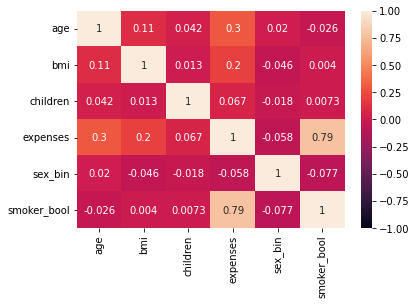

In [13]:
#Correlation Heatmap

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

We can observe in the correlation heatmap, that the valiables expenses and smoker_bool (smoker status) have the highest correlation, in this case a positive correlation of 0.79.

Afterwards valiables age and bmi respectively have a weaker positive correlation with expenses.

In [14]:
#Outliers


def outlier(value, column_index):
  """
    Funcion que calcula rango para determinar outliers para el dataset
  
        Parámetros:
              value (float): Valor que se evaluará para determinar si es outlier.
              column_index (int): índice de la columna de las variable a evaluar.
        
        Return:
              texto, informando si la variable es o no un outlier
  """
  mean = df.describe().iloc[1,column_index] 
  std = df.describe().iloc[2,column_index]


  lower_range = mean - 3*std
  higher_range = mean + 3*std

  if value > higher_range or value < lower_range:
    return print(f"{value} is an outlier")
  else:
    return print(f"{value} is NOT an outlier")

In [15]:
#Checking largest values in the 'age' variable

df.age.nlargest(10)

62     64
94     64
199    64
328    64
335    64
378    64
398    64
402    64
418    64
420    64
Name: age, dtype: int64

In [16]:
#Checking smallest values in the 'age' variable.

df.age.nsmallest(10)

1      18
22     18
31     18
46     18
50     18
57     18
102    18
121    18
157    18
161    18
Name: age, dtype: int64

In [17]:
#Checking outliers for 'age' variable
#Checking largest and smallest values: 64 and 18 respectively

outlier(64, 0)
outlier(18, 0)

64 is NOT an outlier
18 is NOT an outlier


In [18]:
#Checking largest values in the 'bmi' variable

df.bmi.nlargest(10)

1316    53.1
1046    52.6
846     50.4
116     49.1
286     48.1
1087    47.7
859     47.6
401     47.5
543     47.4
438     46.8
Name: bmi, dtype: float64

In [19]:
#Checking smallest values in the 'bmi' variable

df.bmi.nsmallest(10)

172     16.0
428     16.8
1225    16.8
412     17.2
250     17.3
1028    17.3
1285    17.3
28      17.4
679     17.4
410     17.5
Name: bmi, dtype: float64

In [20]:
#Checking outliers for 'bmi' variable
#Chekcing largest and smallest values: 53.1 and 16 respectively

outlier(53.1, 1) #index 1317
outlier(16, 1)

53.1 is an outlier
16 is NOT an outlier


In [20]:
#By determining that 53,1 is an outlier, lets check if other of the largest values also are

outlier(52.6, 1) #1047
outlier(50.4, 1) #847
outlier(49.1, 1) #116 
outlier(48.1, 1) #286

52.6 is an outlier
50.4 is an outlier
49.1 is an outlier
48.1 is NOT an outlier


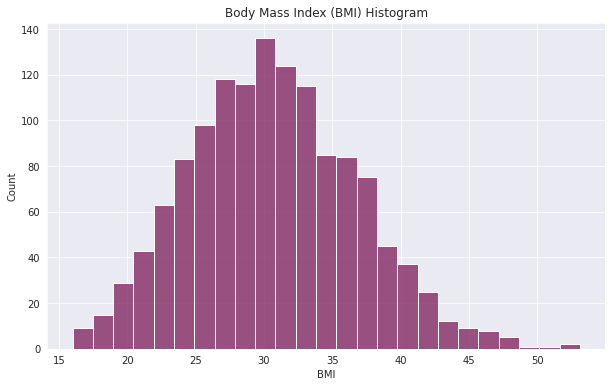

In [21]:
#BMI Histogram

sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
hist = sns.histplot(data=df, x="bmi", color='#7b1c59')
hist.set(xlabel ="BMI",
        ylabel = "Count", 
        title ='Body Mass Index (BMI) Histogram');

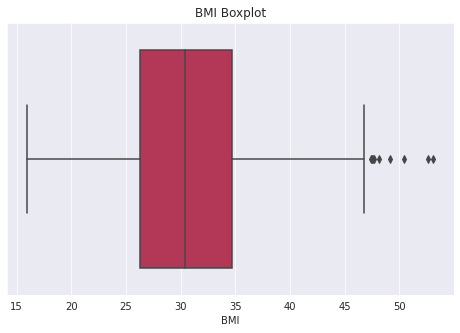

In [24]:
#BMI Boxplot

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
bxplt = sns.boxplot(x=df["bmi"],color='#c7234e');
bxplt.set(xlabel ="BMI",
        title ='BMI Boxplot');

I have decided to keep the outliers in the dataset because of two resons:

1. a BMI over 50 is possible
2. it is not far away from values that are not outliers

In [21]:
df.expenses.nlargest(10)

543     63770.43
1299    62592.87
1229    60021.40
577     58571.07
818     55135.40
1145    52590.83
34      51194.56
1240    49577.66
1061    48970.25
488     48885.14
Name: expenses, dtype: float64

In [22]:
df.expenses.nsmallest(10)

939     1121.87
807     1131.51
1243    1135.94
662     1136.40
22      1137.01
194     1137.47
865     1141.45
780     1146.80
442     1149.40
1316    1163.46
Name: expenses, dtype: float64

In [24]:
#Checking outliers for 'expenses' variable
#Chekcing largest and smallest values:

outlier(63770.43, 3)
outlier(60021.40, 3)
outlier(55135.40, 3)
outlier(51194.56, 3)
outlier(48885.14, 3)

63770.43 is an outlier
60021.4 is an outlier
55135.4 is an outlier
51194.56 is an outlier
48885.14 is NOT an outlier


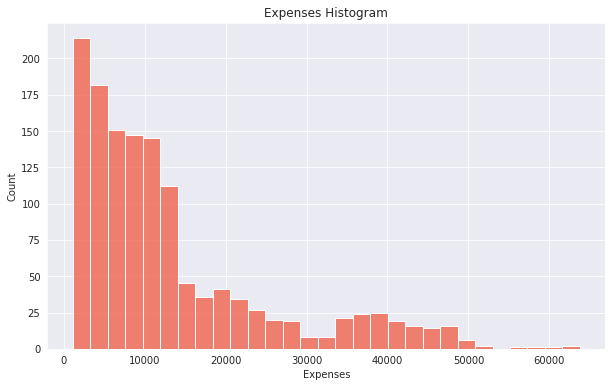

In [25]:
# Expenses Histogram

sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
hist_2 = sns.histplot(data=df, x="expenses", color='#f05b42')
hist_2.set(xlabel ="Expenses",
        ylabel = "Count", 
        title ='Expenses Histogram');

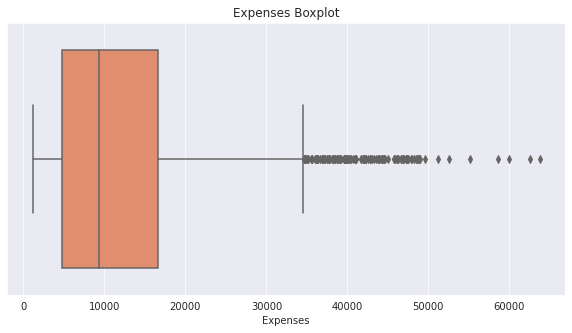

In [26]:
#Expenses Boxplot

sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
bxplt_2 = sns.boxplot(x=df["expenses"],color='#f4845d');
bxplt_2.set(xlabel ="Expenses",
        title ='Expenses Boxplot');

I have decided to keep the expenses outliers in the dataset because of one reason:

1. Health expenses can be very high when having severe or continous health issues.

# 2. Analysis

What variables are most influential for health expenses?

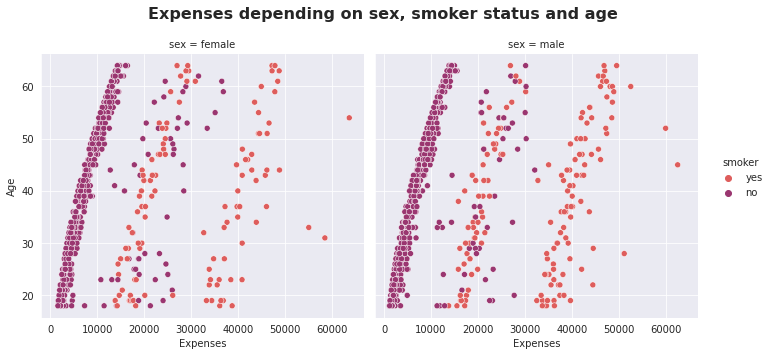

In [33]:
#Scatterplot analyzing expenses level depending on sex, age and somker status.

g = sns.relplot(data=df, 
                x="expenses", 
                y="age", 
                col="sex",
                hue="smoker",
                palette = "flare")

g.set_axis_labels("Expenses", "Age")

g.tight_layout()
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Expenses depending on sex, smoker status and age',
               size=16, 
               weight=900)
plt.show();

We can observe the following:

1. Expenses distributed very similarly between sexes. 

2. Age has a moderate but consistent effect on expenses increase.

3. Expenses increase significantly when people are smokers, regardless of age.


The range of expenses is practically the same between sexes; between close to 0 to a bit over 60.000

In both sexes there are **three** distinct groups:
  - Expenses between 0 - 17.000 that increase consistently with age and are uniquely non-smokers.
  - Expenses between 10.000 - 35.000 that increase more dispersly with age and are smokers and non-smokers in similar proportion.
  - Expenses between 32.000 - 60.000+ that increase more dispered with age and are exclusively smokers.

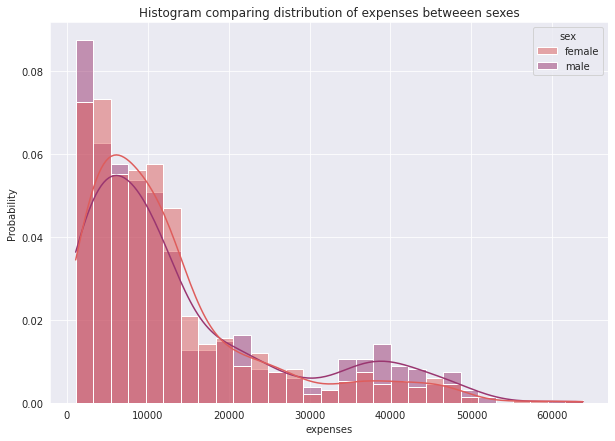

In [45]:
plt.figure(figsize=(10,7))

sns.histplot(data=df, 
             x="expenses", 
             stat="probability", 
             palette = "flare",
             hue="sex",
             kde=True).set(title="Histogram comparing distribution of expenses betweeen sexes");

We can observe that the distribution of expenses between the sexes is fairly similar. 

An interesting observation is that, men have a higher frequency of the lowest health expenses but also higher proportion in the higher health expenses.

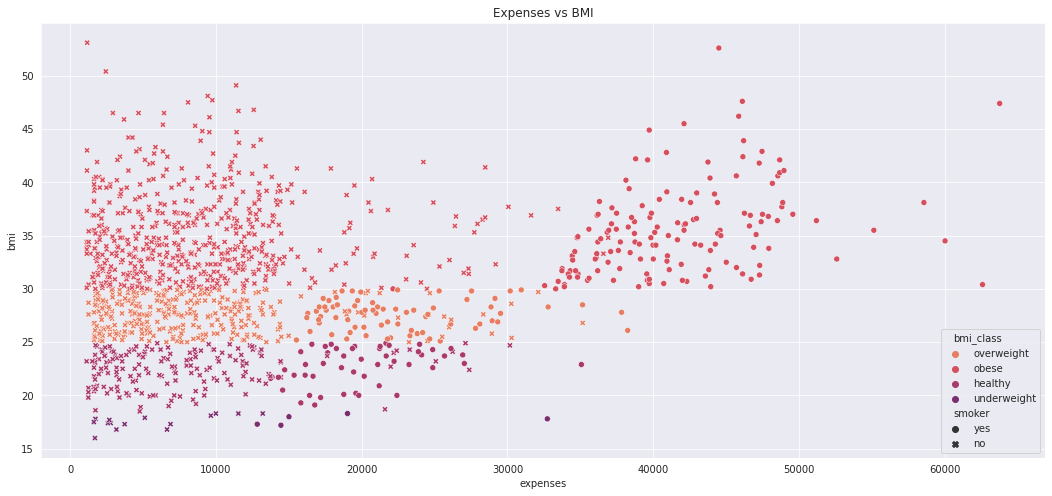

In [50]:
#Scatterplot of Expenses according to BMI and smoker status

plt.figure(figsize=(18,8))
sns.scatterplot(data=df,
              x="expenses", 
              y="bmi", 
              palette = "flare",
              hue="bmi_class",
              style="smoker"
              ).set(title='Expenses vs BMI')

plt.show();

We can observe that for non-smokers bmi is not impactful on the level of health expenses, unlike for smokers.

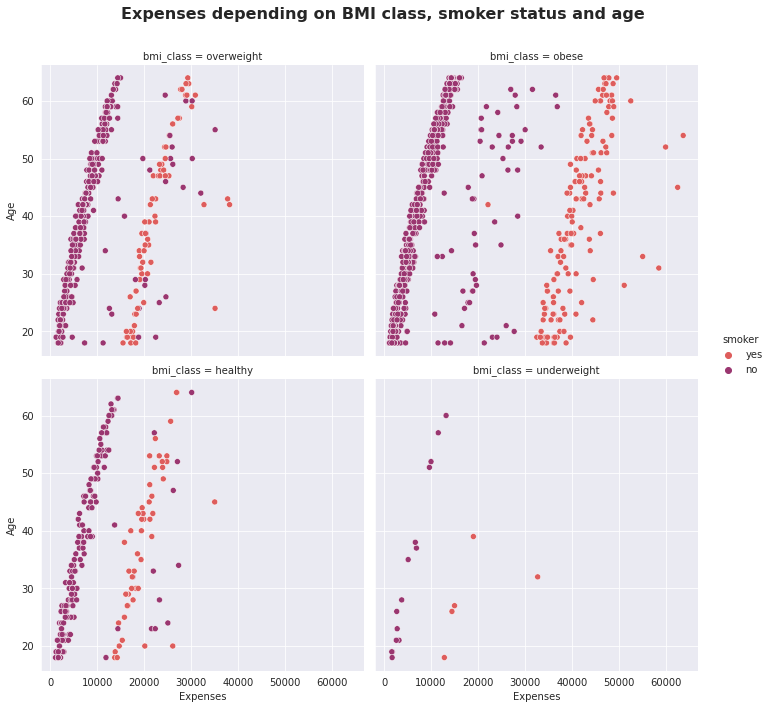

In [48]:
#Scatterplots: Expenses depending on BMI, smoker status and age

g = sns.relplot(data=df, 
                x="expenses", 
                y="age", 
                col="bmi_class",
                hue="smoker",
                palette = "flare",
                col_wrap=2)

g.set_axis_labels("Expenses", "Age")

g.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Expenses depending on BMI class, smoker status and age',
               size=16, 
               weight=900)
plt.show();

When comparing the 4 scatterplots we can conclude the following:


*  In general, non-smokers regardless of BMI classification have lower expenses than smokers.
*  For underweight, healthy and overweight people health expenses can increase 2x - 10 x in the same age range if they are smokers.
* Obese people that smoke have the highest health expenses (over 30.000) and it can be 3x - 40x  higher on the same age range compared to non-smokers that are obese.

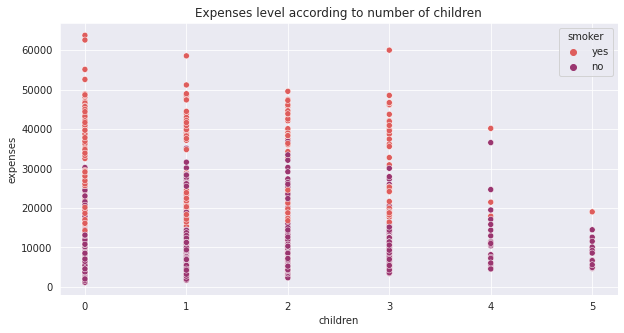

In [85]:
#Scatterplot: Expenses level according to number of children


plt.figure(figsize=(10,5))
sns.scatterplot(data=df,
              x="children", 
              y="expenses", 
              palette = "flare",
              hue="smoker"
              ).set(title='Expenses level according to number of children')
plt.show();

It can be observed that people with 4+ children have lower health expenses but this could be because the number of people in these categories is smaller. Also they are generally non-smokers.

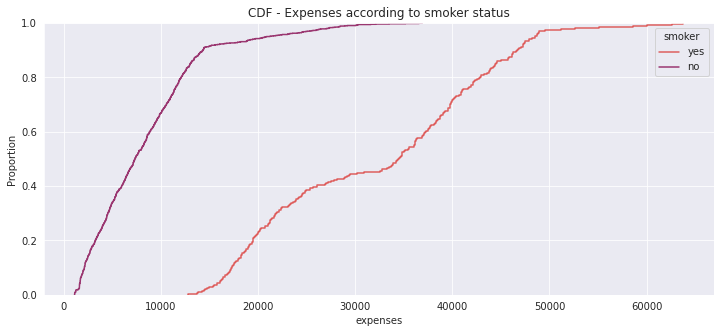

In [87]:
#Cumulative Density Function: Expenses according to smoker status

plt.figure(figsize=(12,5))
sns.ecdfplot(data=df,
             x="expenses",
             hue="smoker", 
             palette = "flare",
             legend=True).set(title='CDF - Expenses according to smoker status')

plt.show();

Through the graph we can observe that non-smokers have a range of expenses between aprox. 1.000 and 37.000 while smokers have a range between 13.000 and 65.000.

We can also conclude that 65%+ of the non-smokers have less than 10.000 on health expenses, while 45%+ of smokers have expenses below 30.000.

In [82]:
# Separate dataset in two dataframes into smokers and non smokers

df_smoker = df.query("smoker == 'yes'")
df_not_smoker = df.query("smoker == 'no'")

In [83]:
print(df.shape)
print(df_smoker.shape)
print(df_not_smoker.shape)

(1338, 10)
(274, 10)
(1064, 10)


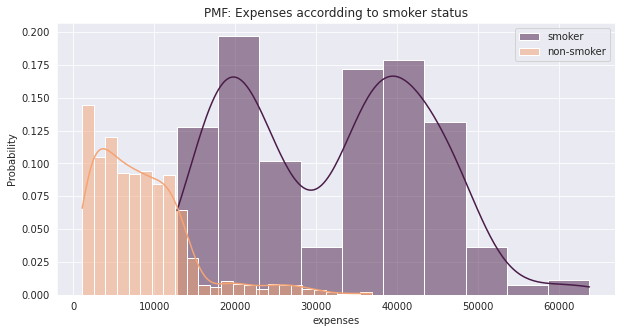

In [94]:
#PMF comparing expenses between smokers and non-smokers

plt.figure(figsize=(10,5))

sns.histplot(data=df_smoker, 
             x="expenses", 
             stat="probability", 
             color="#491c48", 
             label="smoker", 
             kde=True)#, stat='density')

sns.histplot(data=df_not_smoker, 
             x="expenses", 
             stat="probability", 
             color="#f4a474", 
             label="non-smoker", 
             kde=True)#, stat='density')
plt.title('PMF: Expenses accordding to smoker status')
plt.legend() 
plt.show()

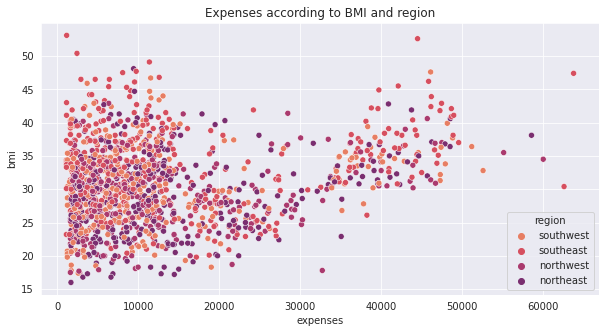

In [49]:
#Scatterplot of Expenses according to BMI and region

plt.figure(figsize=(10,5))
sns.scatterplot(data=df,
              x="expenses", 
              y="bmi", 
              palette = "flare",
              hue="region"
              ).set(title='Expenses according to BMI and region')

plt.show();

Region seems not to be relevant for determinis health expenses.

How relevant is age and BMI for health expenses between smoker and non-smokers?

In [122]:
df_smoker.head()

,age,sex,bmi,children,smoker,region,expenses,sex_bin,smoker_bool,bmi_class
0,19,female,27.9,0,yes,southwest,16884.92,1,True,overweight
11,62,female,26.3,0,yes,southeast,27808.73,1,True,overweight
14,27,male,42.1,0,yes,southeast,39611.76,0,True,obese
19,30,male,35.3,0,yes,southwest,36837.47,0,True,obese
23,34,female,31.9,1,yes,northeast,37701.88,1,True,obese


In [111]:
#To determine effect size between two gropus we use Cohen Effect

def CohenEffectSize(group1, group2):
  """función para calcular el factor d de Cohen"""
  
  diff = group1.mean() - group2.mean()
  var1 = group1.var()
  var2 = group2.var()
  n1, n2 = len(group1), len(group2)
  pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
  d = diff / np.sqrt(pooled_var)
  return round(d,4)

In [113]:
#What's the difference in magnitud of BMI classification between smokers and non-smokers?

CohenEffectSize(df_smoker.bmi, df_not_smoker.bmi)

0.0098

There is no difference in BMI level between smokers and non-smokers.

In [126]:
#What's the difference in magnitud in health expenses between smokers and non-smokers?

CohenEffectSize(df_smoker.expenses, df_not_smoker.expenses)

3.1601

There is a huge difference between group means when it comes to expenses. A 3.1 Cohen Effect Coefficient can be interpreted that smokers have an average of health expenses 3.1 standard deviations higher than non-smokers.

In [128]:
print("Smokers average health expenses:", round(df_smoker.expenses.mean(),3))
print("Non-smokers average health expenses:", round(df_not_smoker.expenses.mean(),3))

Smokers average health expenses: 32050.232
Non-smokers average health expenses: 8434.268


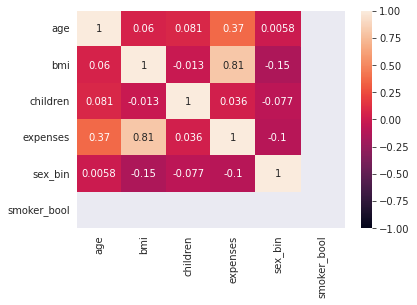

In [129]:
#Correlation Heatmap Smokers

sns.heatmap(df_smoker.corr(), vmin=-1, vmax=1, annot=True);

For smokers we can observe that:

*  age has a low positive correlation with expenses -> Corr = 0.37
*  bmi has a high positive correlatio with expenses. -> Corr = 0.81

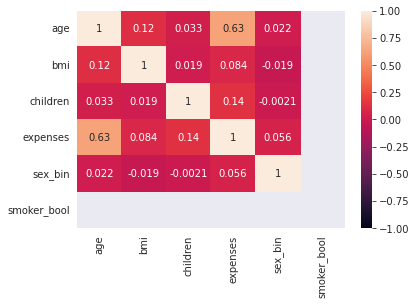

In [125]:
#Correlation Heatmap Non-smokers

sns.heatmap(df_not_smoker.corr(), vmin=-1, vmax=1, annot=True);

For non-smokers we can observe that:

*  age has a moderate positive correlation with expenses -> Corr = 0.63
*  bmi has no correlation with expenses --> Corr= 0.084